<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/Adaboost(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STEP 1: LOADING AND PREPROCESSING DATA
Loading datasets...
Train set shape: (3584, 84)
Validation set shape: (768, 84)
Test set shape: (768, 84)
Production quantiles:
Very Low: <550.20
Low: 550.20 - 1447.52
Medium: 1447.52 - 3064.52
High: 3064.52 - 6362.60
Very High: >6362.60

Label distribution:
Training: Label
High         717
Low          717
Medium       716
Very High    717
Very Low     717
Name: count, dtype: int64
Validation: Label
High         157
Low          147
Medium       153
Very High    151
Very Low     160
Name: count, dtype: int64
Testing: Label
High         136
Low          151
Medium       163
Very High    167
Very Low     151
Name: count, dtype: int64

STEP 2: TRAINING MODEL

Training AdaBoost model with 100 estimators...
Estimators: 20, Train Acc: 0.7165, Val Acc: 0.6784
Estimators: 40, Train Acc: 0.7391, Val Acc: 0.7018
Estimators: 60, Train Acc: 0.7467, Val Acc: 0.7214
Estimators: 80, Train Acc: 0.7586, Val Acc: 0.7331
Estimators: 100, Train Acc: 0.7617, Val Acc:

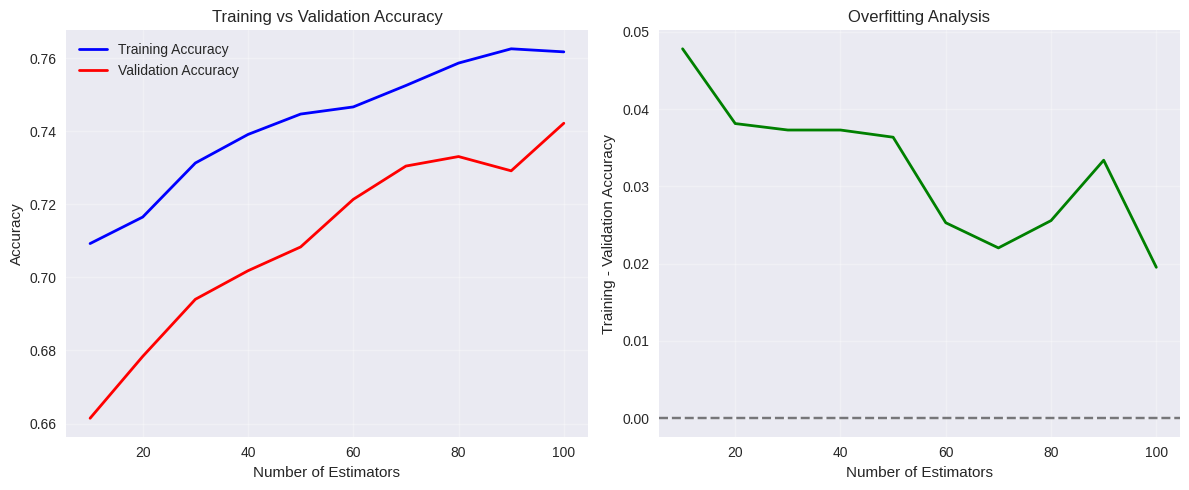

Plotting class distributions...


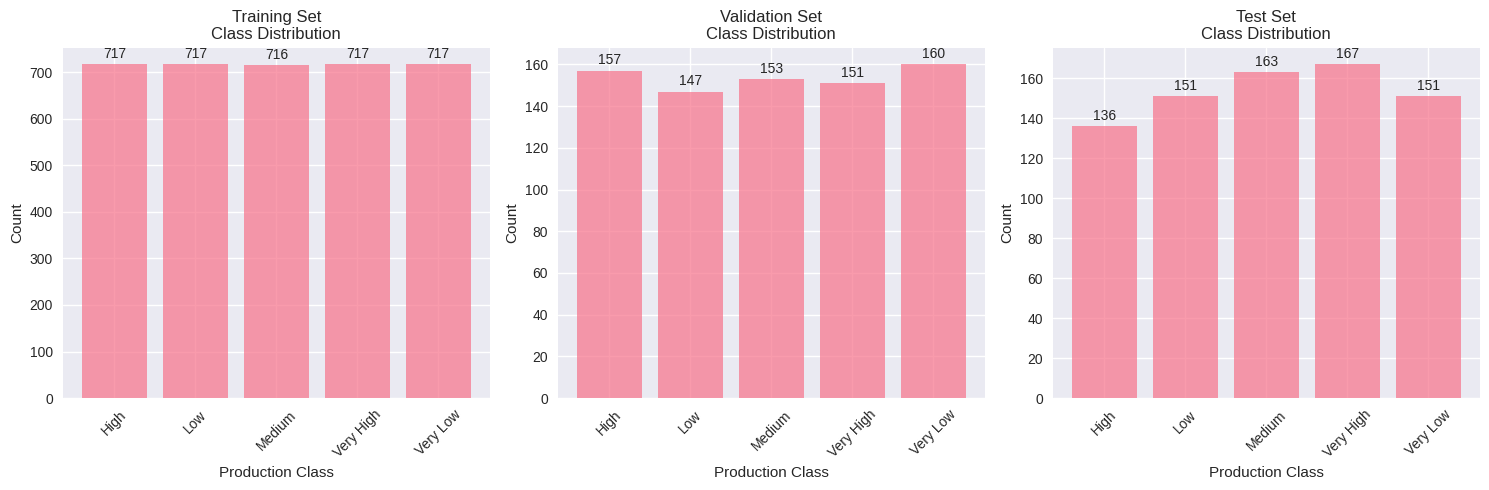

Plotting confusion matrices...


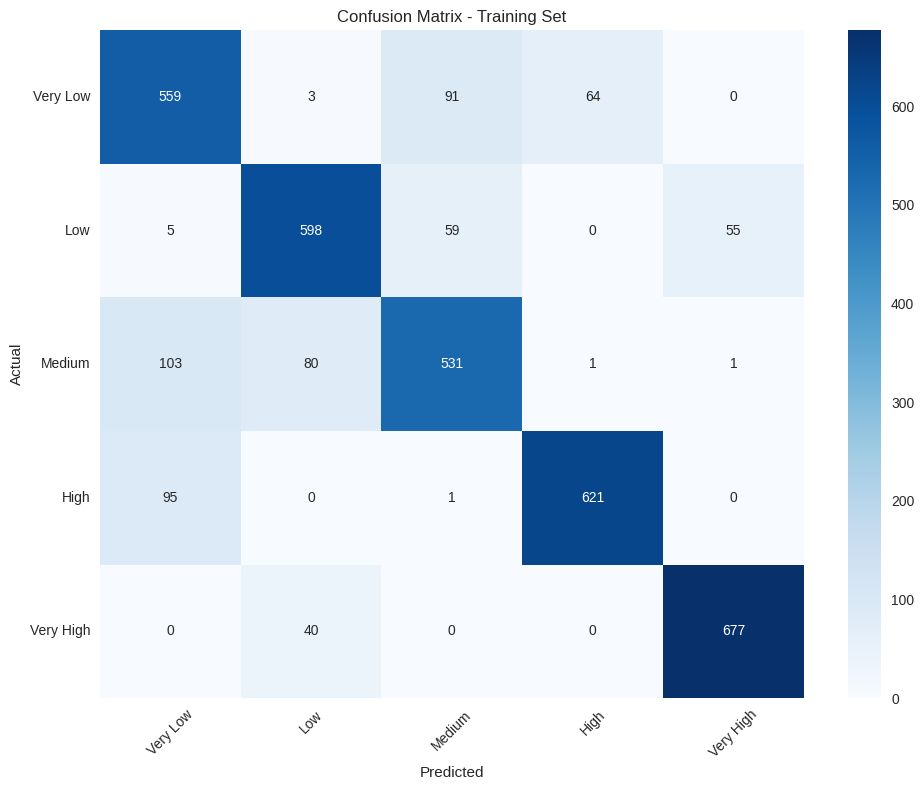

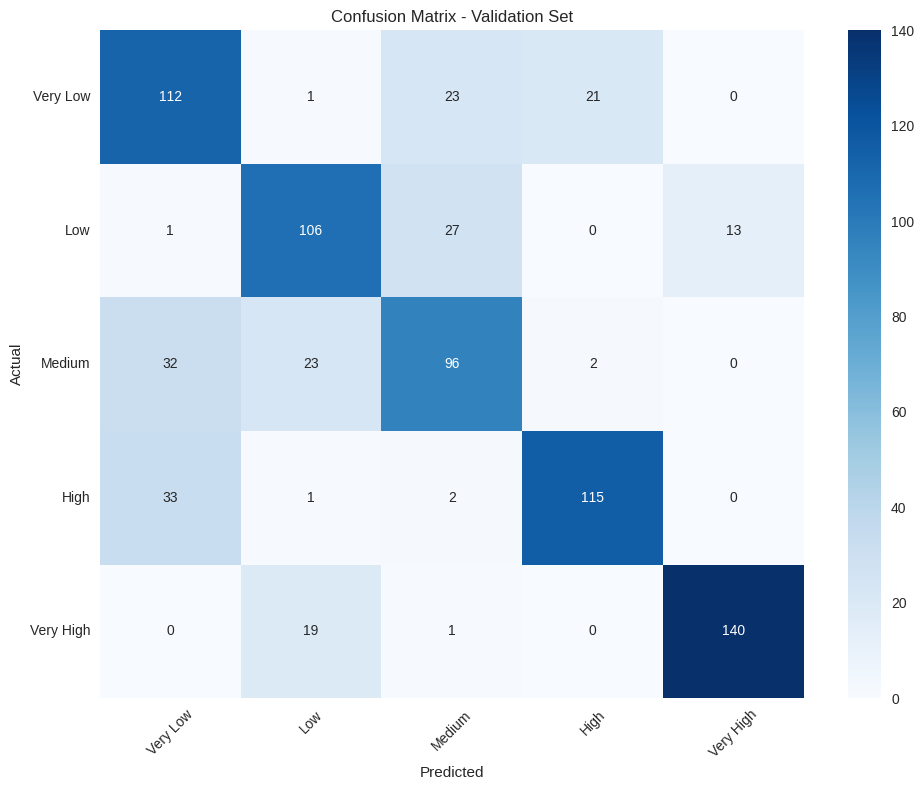

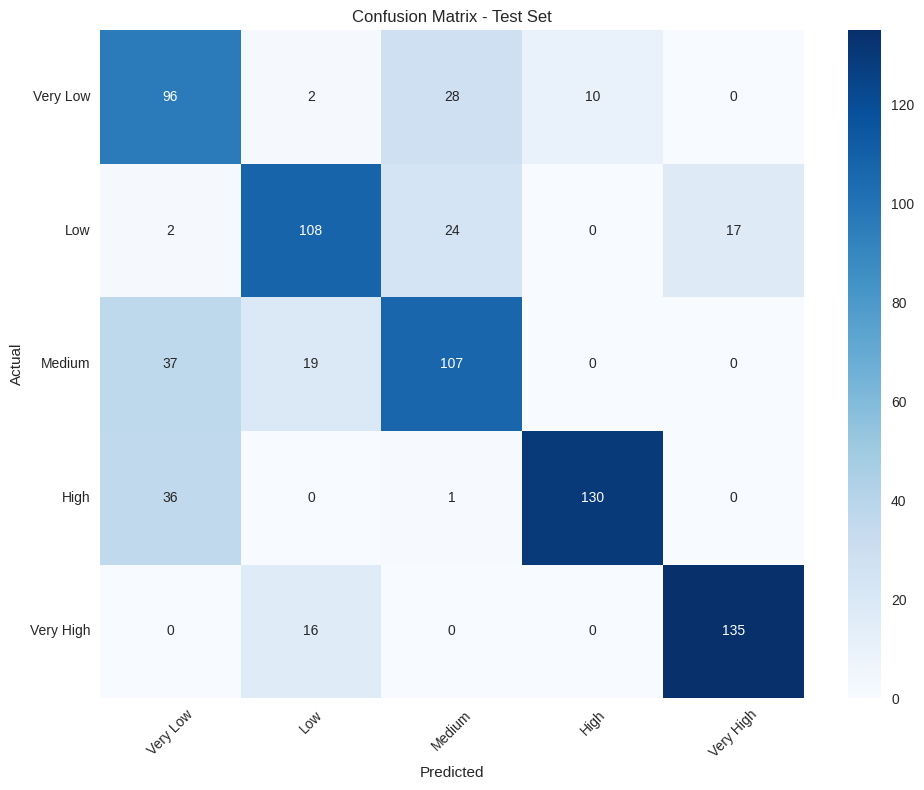

Plotting Macro F1 Score comparison...


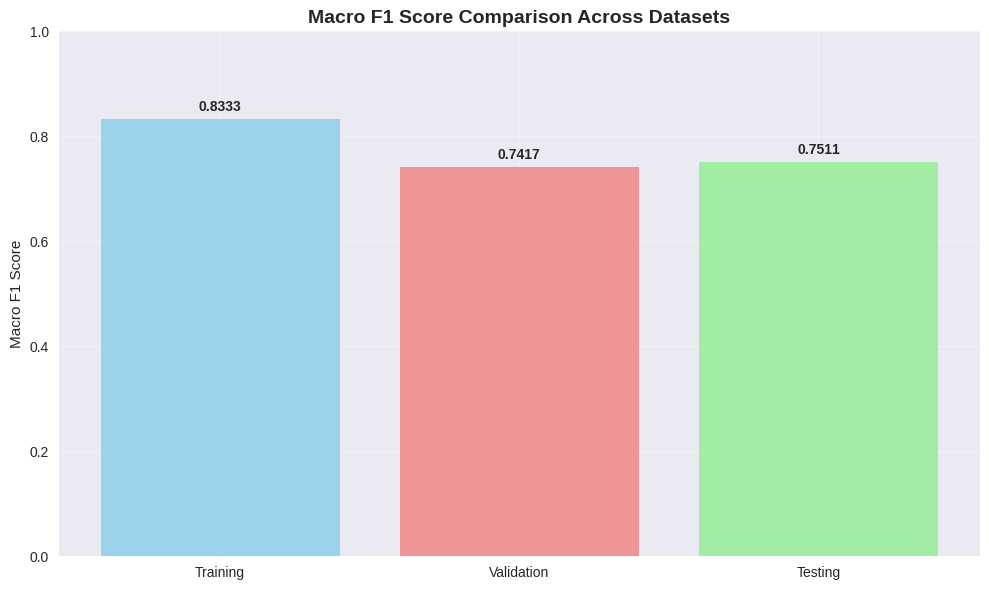

Plotting feature importance...


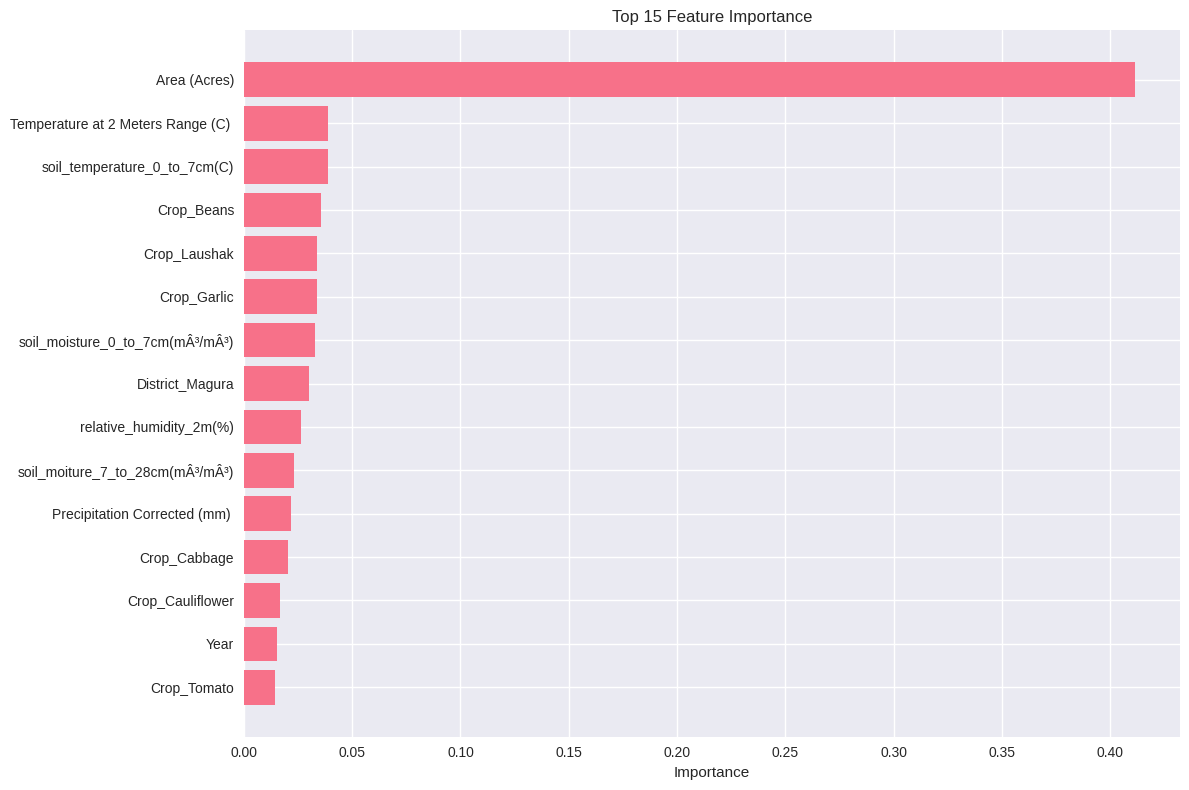


STEP 7: FINAL SUMMARY

Final Performance Summary:
      Dataset  Accuracy  Precision  Recall  F1-Weighted  F1-Macro
0    Training    0.8331     0.8341  0.8331       0.8333    0.8333
1  Validation    0.7409     0.7467  0.7409       0.7428    0.7417
2     Testing    0.7500     0.7643  0.7500       0.7542    0.7511

MACRO F1 SCORE ANALYSIS
Training:   0.8333
Validation: 0.7417
Testing:    0.7511

Performance Analysis:
✓ Good validation performance (Macro F1 > 0.7)
✓ Good generalization (gap: 0.0915)
✓ Consistent performance on test set (gap: -0.0094)


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report)
from sklearn.model_selection import validation_curve
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class AdaBoostProductionClassifier:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_names = None
        self.class_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

    def load_and_preprocess_data(self, train_path, val_path, test_path):
        """Load and preprocess the datasets"""
        print("Loading datasets...")

        # Load datasets
        train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
        val_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
        test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')

        print(f"Train set shape: {train_df.shape}")
        print(f"Validation set shape: {val_df.shape}")
        print(f"Test set shape: {test_df.shape}")

        # Create labels based on production quantiles (using training data)
        production_col = 'Production (M.Ton)'

        # Calculate quantiles from training data for 5 classes
        quantiles = train_df[production_col].quantile([0.2, 0.4, 0.6, 0.8]).values
        print(f"Production quantiles:")
        print(f"Very Low: <{quantiles[0]:.2f}")
        print(f"Low: {quantiles[0]:.2f} - {quantiles[1]:.2f}")
        print(f"Medium: {quantiles[1]:.2f} - {quantiles[2]:.2f}")
        print(f"High: {quantiles[2]:.2f} - {quantiles[3]:.2f}")
        print(f"Very High: >{quantiles[3]:.2f}")

        # Create labels for all datasets
        def create_labels(df, q1, q2, q3, q4):
            labels = []
            for prod in df[production_col]:
                if prod <= q1:
                    labels.append('Very Low')
                elif prod <= q2:
                    labels.append('Low')
                elif prod <= q3:
                    labels.append('Medium')
                elif prod <= q4:
                    labels.append('High')
                else:
                    labels.append('Very High')
            return labels

        train_df['Label'] = create_labels(train_df, quantiles[0], quantiles[1], quantiles[2], quantiles[3])
        val_df['Label'] = create_labels(val_df, quantiles[0], quantiles[1], quantiles[2], quantiles[3])
        test_df['Label'] = create_labels(test_df, quantiles[0], quantiles[1], quantiles[2], quantiles[3])

        # Separate features and labels
        feature_cols = [col for col in train_df.columns if col not in [production_col, 'Label']]
        self.feature_names = feature_cols

        X_train = train_df[feature_cols]
        y_train = train_df['Label']
        X_val = val_df[feature_cols]
        y_val = val_df['Label']
        X_test = test_df[feature_cols]
        y_test = test_df['Label']

        # Handle missing values
        X_train = X_train.fillna(X_train.mean())
        X_val = X_val.fillna(X_train.mean())  # Use training mean for consistency
        X_test = X_test.fillna(X_train.mean())

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)

        # Encode labels
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        y_val_encoded = self.label_encoder.transform(y_val)
        y_test_encoded = self.label_encoder.transform(y_test)

        print("\nLabel distribution:")
        print("Training:", pd.Series(y_train).value_counts().sort_index())
        print("Validation:", pd.Series(y_val).value_counts().sort_index())
        print("Testing:", pd.Series(y_test).value_counts().sort_index())

        return (X_train_scaled, X_val_scaled, X_test_scaled,
                y_train_encoded, y_val_encoded, y_test_encoded,
                y_train, y_val, y_test)

    def train_model_with_epochs(self, X_train, y_train, X_val, y_val, n_epochs=100):
        """Train AdaBoost model with epoch-like iterations"""
        print(f"\nTraining AdaBoost model with {n_epochs} estimators...")

        # Initialize model
        base_estimator = DecisionTreeClassifier(max_depth=4, random_state=42)
        self.model = AdaBoostClassifier(
            estimator=base_estimator,
            n_estimators=n_epochs,
            learning_rate=1.0,
            random_state=42
        )

        # For tracking performance over epochs
        train_accuracies = []
        val_accuracies = []
        epochs = []

        # Train with increasing number of estimators to simulate epochs
        for n_est in range(10, n_epochs + 1, 10):
            temp_model = AdaBoostClassifier(
                estimator=DecisionTreeClassifier(max_depth=4, random_state=42),
                n_estimators=n_est,
                learning_rate=0.1,
                random_state=42
            )
            temp_model.fit(X_train, y_train)

            train_pred = temp_model.predict(X_train)
            val_pred = temp_model.predict(X_val)

            train_acc = accuracy_score(y_train, train_pred)
            val_acc = accuracy_score(y_val, val_pred)

            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            epochs.append(n_est)

            if n_est % 20 == 0:
                print(f"Estimators: {n_est}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Final training
        self.model.fit(X_train, y_train)
        print("Training completed!")

        return epochs, train_accuracies, val_accuracies

    def calculate_metrics(self, y_true, y_pred, dataset_name):
        """Calculate comprehensive classification metrics"""
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

        print(f"\n{dataset_name} Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Weighted): {precision:.4f}")
        print(f"Recall (Weighted): {recall:.4f}")
        print(f"F1-Score (Weighted): {f1_weighted:.4f}")
        print(f"F1-Score (Macro): {f1_macro:.4f}")

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro
        }

    def plot_confusion_matrix(self, y_true, y_pred, title):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names,
                    yticklabels=self.class_names)
        plt.title(f'Confusion Matrix - {title}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        return cm

    def plot_training_curves(self, epochs, train_acc, val_acc):
        """Plot training vs validation accuracy"""
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2)
        plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
        plt.xlabel('Number of Estimators')
        plt.ylabel('Accuracy')
        plt.title('Training vs Validation Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, np.array(train_acc) - np.array(val_acc), 'g-', linewidth=2)
        plt.xlabel('Number of Estimators')
        plt.ylabel('Training - Validation Accuracy')
        plt.title('Overfitting Analysis')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

    def plot_macro_f1_comparison(self, train_metrics, val_metrics, test_metrics):
        """Plot Macro F1 Score comparison across datasets"""
        datasets = ['Training', 'Validation', 'Testing']
        macro_f1_scores = [train_metrics['f1_macro'], val_metrics['f1_macro'], test_metrics['f1_macro']]

        plt.figure(figsize=(10, 6))
        bars = plt.bar(datasets, macro_f1_scores, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8)
        plt.title('Macro F1 Score Comparison Across Datasets', fontsize=14, fontweight='bold')
        plt.ylabel('Macro F1 Score')
        plt.ylim(0, 1)

        # Add value labels on bars
        for bar, score in zip(bars, macro_f1_scores):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    def plot_feature_importance(self, top_n=15):
        """Plot feature importance"""
        if self.model is None:
            print("Model not trained yet!")
            return

        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1][:top_n]

        plt.figure(figsize=(12, 8))
        plt.title(f'Top {top_n} Feature Importance')
        plt.barh(range(top_n), importances[indices])
        plt.yticks(range(top_n), [self.feature_names[i] for i in indices])
        plt.xlabel('Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    def plot_class_distribution(self, y_train, y_val, y_test):
        """Plot class distribution across datasets"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        datasets = [y_train, y_val, y_test]
        titles = ['Training Set', 'Validation Set', 'Test Set']

        for i, (data, title) in enumerate(zip(datasets, titles)):
            value_counts = pd.Series(data).value_counts().sort_index()
            axes[i].bar(value_counts.index, value_counts.values, alpha=0.7)
            axes[i].set_title(f'{title}\nClass Distribution')
            axes[i].set_xlabel('Production Class')
            axes[i].set_ylabel('Count')
            axes[i].tick_params(axis='x', rotation=45)

            # Add value labels on bars
            for j, v in enumerate(value_counts.values):
                axes[i].text(j, v + max(value_counts.values) * 0.01, str(v),
                           ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def generate_classification_report(self, y_true, y_pred, dataset_name):
        """Generate detailed classification report"""
        print(f"\n{dataset_name} Classification Report:")
        print("=" * 50)
        report = classification_report(y_true, y_pred,
                                     target_names=self.class_names,
                                     digits=4)
        print(report)
        return report

# Main execution function
def main():
    """Main function to run the complete pipeline"""

    # Initialize classifier
    classifier = AdaBoostProductionClassifier()

    # File paths (update these paths according to your file locations)
    train_path = '/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv'
    val_path = '/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv'
    test_path = '/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv'


    try:
        # Step 1: Load and preprocess data
        print("="*60)
        print("STEP 1: LOADING AND PREPROCESSING DATA")
        print("="*60)

        (X_train, X_val, X_test,
         y_train_enc, y_val_enc, y_test_enc,
         y_train_orig, y_val_orig, y_test_orig) = classifier.load_and_preprocess_data(
            train_path, val_path, test_path)

        # Step 2: Train model
        print("\n" + "="*60)
        print("STEP 2: TRAINING MODEL")
        print("="*60)

        epochs, train_acc, val_acc = classifier.train_model_with_epochs(
            X_train, y_train_enc, X_val, y_val_enc, n_epochs=100)

        # Step 3: Make predictions
        print("\n" + "="*60)
        print("STEP 3: MAKING PREDICTIONS")
        print("="*60)

        train_pred = classifier.model.predict(X_train)
        val_pred = classifier.model.predict(X_val)
        test_pred = classifier.model.predict(X_test)

        # Step 4: Calculate metrics
        print("\n" + "="*60)
        print("STEP 4: EVALUATION METRICS")
        print("="*60)

        train_metrics = classifier.calculate_metrics(y_train_enc, train_pred, "TRAINING")
        val_metrics = classifier.calculate_metrics(y_val_enc, val_pred, "VALIDATION")
        test_metrics = classifier.calculate_metrics(y_test_enc, test_pred, "TESTING")

        # Step 5: Generate detailed reports
        print("\n" + "="*60)
        print("STEP 5: DETAILED CLASSIFICATION REPORTS")
        print("="*60)

        classifier.generate_classification_report(y_train_enc, train_pred, "TRAINING")
        classifier.generate_classification_report(y_val_enc, val_pred, "VALIDATION")
        classifier.generate_classification_report(y_test_enc, test_pred, "TESTING")

        # Step 6: Visualizations
        print("\n" + "="*60)
        print("STEP 6: GENERATING VISUALIZATIONS")
        print("="*60)

        # Plot training curves
        print("Plotting training curves...")
        classifier.plot_training_curves(epochs, train_acc, val_acc)

        # Plot class distributions
        print("Plotting class distributions...")
        classifier.plot_class_distribution(y_train_orig, y_val_orig, y_test_orig)

        # Plot confusion matrices
        print("Plotting confusion matrices...")
        classifier.plot_confusion_matrix(y_train_enc, train_pred, "Training Set")
        classifier.plot_confusion_matrix(y_val_enc, val_pred, "Validation Set")
        classifier.plot_confusion_matrix(y_test_enc, test_pred, "Test Set")

        # Plot Macro F1 Score comparison
        print("Plotting Macro F1 Score comparison...")
        classifier.plot_macro_f1_comparison(train_metrics, val_metrics, test_metrics)

        # Plot feature importance
        print("Plotting feature importance...")
        classifier.plot_feature_importance()

        # Step 7: Summary
        print("\n" + "="*60)
        print("STEP 7: FINAL SUMMARY")
        print("="*60)

        summary_df = pd.DataFrame({
            'Dataset': ['Training', 'Validation', 'Testing'],
            'Accuracy': [train_metrics['accuracy'], val_metrics['accuracy'], test_metrics['accuracy']],
            'Precision': [train_metrics['precision'], val_metrics['precision'], test_metrics['precision']],
            'Recall': [train_metrics['recall'], val_metrics['recall'], test_metrics['recall']],
            'F1-Weighted': [train_metrics['f1_weighted'], val_metrics['f1_weighted'], test_metrics['f1_weighted']],
            'F1-Macro': [train_metrics['f1_macro'], val_metrics['f1_macro'], test_metrics['f1_macro']]
        })

        print("\nFinal Performance Summary:")
        print(summary_df.round(4))

        # Macro F1 Score emphasis
        print(f"\n" + "="*60)
        print("MACRO F1 SCORE ANALYSIS")
        print("="*60)
        print(f"Training:   {train_metrics['f1_macro']:.4f}")
        print(f"Validation: {val_metrics['f1_macro']:.4f}")
        print(f"Testing:    {test_metrics['f1_macro']:.4f}")

        # Performance analysis
        print(f"\nPerformance Analysis:")
        if val_metrics['f1_macro'] > 0.7:
            print("✓ Good validation performance (Macro F1 > 0.7)")
        elif val_metrics['f1_macro'] > 0.5:
            print("⚠ Moderate validation performance (Macro F1 > 0.5)")
        else:
            print("✗ Poor validation performance (Macro F1 ≤ 0.5)")

        overfitting_gap = train_metrics['f1_macro'] - val_metrics['f1_macro']
        if overfitting_gap > 0.1:
            print(f"⚠ Potential overfitting detected (gap: {overfitting_gap:.4f})")
        else:
            print(f"✓ Good generalization (gap: {overfitting_gap:.4f})")

        generalization_gap = val_metrics['f1_macro'] - test_metrics['f1_macro']
        if abs(generalization_gap) < 0.05:
            print(f"✓ Consistent performance on test set (gap: {generalization_gap:.4f})")
        else:
            print(f"⚠ Performance difference on test set (gap: {generalization_gap:.4f})")

    except FileNotFoundError as e:
        print(f"Error: Could not find one of the CSV files. Please make sure the following files exist:")
        print(f"- {train_path}")
        print(f"- {val_path}")
        print(f"- {test_path}")
        print(f"\nError details: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")
        print("Please check your data files and try again.")

# Run the main function
if __name__ == "__main__":
    main()